# Benchmarks

[![Colab link](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeertmans/sampling-paths/blob/main/notebooks/benchmark.ipynb)

This minimalist notebook contains the code to run benchmarks on the sampling paths model.

The whole process (GPU and CPU) should run in less than 3 days on a standard workstation with a modest GPU (see paper for hardware details).

In [ ]:
# Run this cell to install this project and its dependencies, e.g., on Google Colab

try:
    import sampling_paths  # noqa: F401
except ImportError:
    import sys  # noqa: F401

    !{sys.executable} -m pip install git+https://github.com/jeertmans/sampling-paths.git

In [ ]:
import json
import statistics
from collections import defaultdict

import equinox as eqx
import jax
import jax.random as jr
import matplotlib.pyplot as plt
from differt.scene import TriangleScene
from jaxtyping import Array, Int, PRNGKeyArray
from sampling_paths.model import Model
from sampling_paths.utils import random_scene
from tqdm.notebook import tqdm

Devices:   0%|          | 0/1 [00:00<?, ?it/s]

Orders:   0%|          | 0/3 [00:00<?, ?it/s]

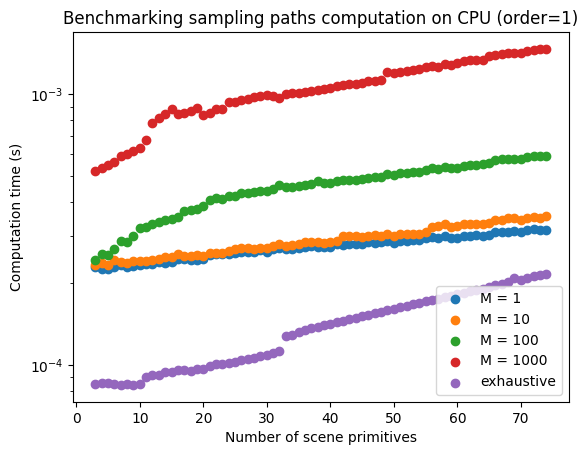

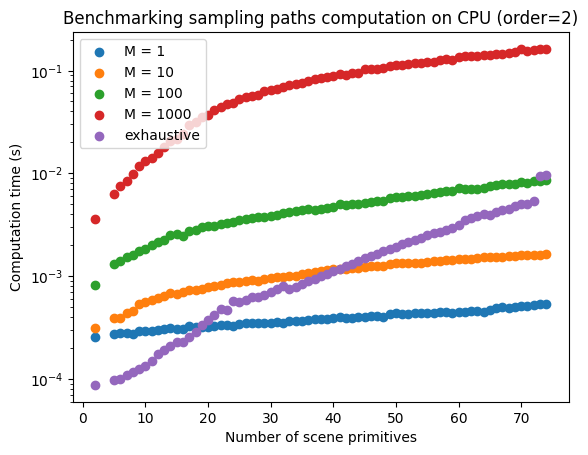

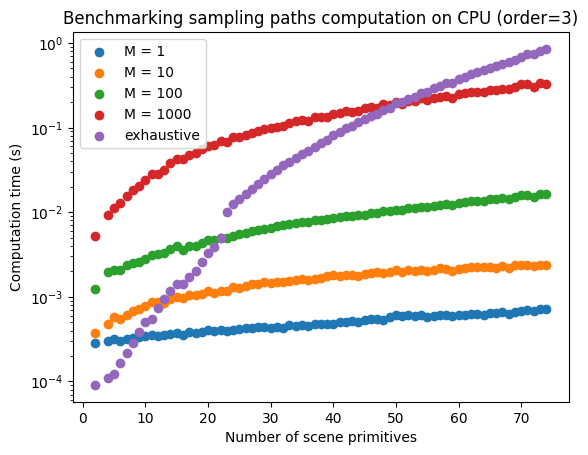

In [ ]:
@eqx.filter_jit
def bench_fun(
    model: Model,
    scene: TriangleScene,
    batch_size: int,
    key: PRNGKeyArray | None,
) -> Int[Array, ""]:
    if key is not None:
        path_candidates = jax.vmap(lambda key: model(scene, key=key))(
            jr.split(key, batch_size)
        )
        paths = scene.compute_paths(path_candidates=path_candidates)
    else:
        paths = scene.compute_paths(order=model.order)
    return paths.mask.sum()


devices = ["cpu"]  # Change to ["gpu", "cpu"] to benchmark on GPU as well

for device in tqdm(devices, desc="Devices", leave=False):
    with jax.default_device(jax.devices(device)[0]):
        key = jr.key(1234)

        for order, order_key in enumerate(
            tqdm(jr.split(key, 3), desc="Orders", leave=False), start=1
        ):
            model_key, stats_key = jr.split(order_key)
            model = Model(
                order=order,
                num_embeddings=64,
                width_size=128,
                depth=2,
                inference=True,
                key=model_key,
            )

            stats = defaultdict(lambda: defaultdict(list))

            for scene_key in tqdm(
                jr.split(stats_key, 1000),
                desc="Collecting statistics over multiple scenes",
                leave=False,
            ):
                scene = random_scene(
                    min_fill_factor=0.1,
                    max_fill_factor=1.0,
                    sample_objects=False,
                    include_floor=False,
                    key=scene_key,
                )
                # We drop masked objects to reduce the size of the exhaustive search, for a fair comparison
                scene = eqx.tree_at(
                    lambda s: s.mesh, scene, scene.mesh.masked()
                )
                n = scene.mesh.num_primitives
                for batch_size in [1, 10, 100, 1000]:
                    # Benchmark our model (reusing random keys is not a problem here)
                    bench_fun(
                        model, scene, batch_size=batch_size, key=jr.key(0)
                    )
                    %timeit -q -v t bench_fun(model, scene, batch_size=batch_size, key=jr.key(1)).block_until_ready()
                    stats[batch_size][n].append(t.average)  # type: ignore[unresolved-reference]  # noqa: F821

                # Benchmark exhaustive method
                bench_fun(model, scene, batch_size=batch_size, key=None)
                %timeit -q -v t bench_fun(model, scene, batch_size=batch_size, key=None).block_until_ready()
                stats[None][n].append(t.average)  # type: ignore[unresolved-reference]  # noqa: F821

            results = {}
            plt.figure()
            for batch_size in stats:
                ns = []
                ts = []
                for n in stats[batch_size]:
                    ns.append(n)
                    ts.append(statistics.mean(stats[batch_size][n]))

                results[batch_size] = (ns, ts)

                label = (
                    f"M = {batch_size}"
                    if batch_size is not None
                    else "exhaustive"
                )
                plt.scatter(ns, ts, label=label)

            with open(f"{device}_benchmarks_{order}.json", "w") as f:
                json.dump(results, f)

            plt.legend()
            plt.yscale("log")
            plt.xlabel("Number of scene primitives")
            plt.ylabel("Computation time (s)")
            plt.title(
                f"Benchmarking sampling paths computation on {device.upper()} (order={order})"
            )
            plt.savefig(f"{device}_benchmarks_{order}.pdf")
            plt.show()